# Interactive Sector and Trajectory Visualization

This notebook provides an interactive interface to:
1. Select a reference sector from the flow groups log
2. Visualize all trajectories of flights passing through that reference sector
3. Display the reference sector
4. Manually specify and display a hotspot sector

**Data Source:** `output/flow_extraction/flow_groups_MASB5KL_hour_6.txt`

In [8]:
import json
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point, LineString
import sys
import os
from ipywidgets import interact, widgets, HBox, VBox
from IPython.display import display, clear_output

# Add the project source to path for imports
sys.path.append('../src')
from project_tailwind.impact_eval.tvtw_indexer import TVTWIndexer

plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)

## Load Data

In [9]:
# Load flow groups data
flow_groups = []
with open('../output/flow_extraction/flow_groups_MASB5KL_hour_6.txt', 'r') as f:
    for line in f:
        if line.strip():
            try:
                data = json.loads(line.strip())
                flow_groups.append(data)
            except json.JSONDecodeError:
                continue

# Load traffic volumes
traffic_volumes = gpd.read_file('/Volumes/CrucialX/project-cirrus/cases/traffic_volumes_with_capacity.geojson')

# Load CSV trajectory data
trajectory_df = pd.read_csv('/Volumes/CrucialX/project-cirrus/cases/flights_20230801.csv')

print(f"Loaded {len(flow_groups)} flow groups")
print(f"Loaded {len(traffic_volumes)} traffic volumes")
print(f"Loaded {len(trajectory_df)} trajectory segments")

# Get unique reference sectors for dropdown
reference_sectors = sorted(list(set([group['reference_sector'] for group in flow_groups])))
print(f"\nFound {len(reference_sectors)} unique reference sectors")

Skipping field elementary_sectors: unsupported OGR type: 5


Loaded 1492 flow groups
Loaded 1612 traffic volumes
Loaded 1214748 trajectory segments

Found 141 unique reference sectors


## Utility Functions

In [10]:
def get_flight_trajectory(flight_id, trajectory_df):
    """
    Extract flight trajectory from CSV data
    """
    if isinstance(flight_id, str):
        flight_id = int(flight_id)
    flight_segments = trajectory_df[trajectory_df['flight_identifier'] == flight_id].copy()
    
    if flight_segments.empty:
        return None
    
    # Sort by sequence
    flight_segments = flight_segments.sort_values('sequence')
    
    # Create trajectory coordinates
    coordinates = []
    first_segment = flight_segments.iloc[0]
    coordinates.append((first_segment['longitude_begin'], first_segment['latitude_begin']))
    
    for _, segment in flight_segments.iterrows():
        coordinates.append((segment['longitude_end'], segment['latitude_end']))
    
    # Create trajectory geometry
    trajectory_geom = LineString(coordinates)
    
    # Get flight metadata
    flight_info = {
        'flight_identifier': flight_id,
        'call_sign': first_segment['call_sign'],
        'origin': first_segment['origin_aerodrome'],
        'destination': first_segment['destination_aerodrome'],
        'geometry': trajectory_geom,
        'num_segments': len(flight_segments)
    }
    
    return flight_info

def get_sector_geometry(sector_id, traffic_volumes):
    """
    Get geometry for a specific sector/traffic volume
    """
    sector_data = traffic_volumes[traffic_volumes['traffic_volume_id'] == sector_id]
    if sector_data.empty:
        return None
    return sector_data.iloc[0]

def get_flows_for_reference_sector(reference_sector, flow_groups):
    """
    Get all flow groups for a specific reference sector
    """
    matching_flows = [group for group in flow_groups if group['reference_sector'] == reference_sector]
    return matching_flows

## Visualization Function

In [11]:
def plot_sector_trajectories(reference_sector, hotspot_sector, traffic_volumes, trajectory_df, flow_groups):
    """
    Plot trajectories for flights passing through the reference sector,
    along with the reference sector and hotspot sector
    """
    # Get flows for the reference sector
    matching_flows = get_flows_for_reference_sector(reference_sector, flow_groups)
    
    if not matching_flows:
        print(f"❌ No flows found for reference sector: {reference_sector}")
        return
    
    # Collect all flight IDs
    all_flight_ids = set()
    for flow in matching_flows:
        all_flight_ids.update(flow['group_flights'])
    
    print(f"\n🔍 Analysis for Reference Sector: {reference_sector}")
    print(f"   📊 Found {len(matching_flows)} flow groups")
    print(f"   ✈️  Total unique flights: {len(all_flight_ids)}")
    
    # Get trajectories for all flights
    trajectories = []
    for flight_id in all_flight_ids:
        traj = get_flight_trajectory(flight_id, trajectory_df)
        if traj:
            trajectories.append(traj)
    
    print(f"   📍 Successfully loaded {len(trajectories)} trajectories")
    
    # Get sector geometries
    reference_sector_geom = get_sector_geometry(reference_sector, traffic_volumes)
    hotspot_sector_geom = get_sector_geometry(hotspot_sector, traffic_volumes) if hotspot_sector else None
    
    if reference_sector_geom is None:
        print(f"⚠️  Warning: Reference sector '{reference_sector}' not found in traffic volumes")
    
    if hotspot_sector and hotspot_sector_geom is None:
        print(f"⚠️  Warning: Hotspot sector '{hotspot_sector}' not found in traffic volumes")
    
    # Create the plot
    fig = plt.figure(figsize=(18, 12))
    ax = plt.axes(projection=ccrs.PlateCarree())
    
    # Calculate bounds from trajectories and sectors
    all_bounds = []
    
    # Add trajectory bounds
    for traj in trajectories:
        all_bounds.append(traj['geometry'].bounds)
    
    # Add sector bounds
    if reference_sector_geom is not None:
        all_bounds.append(reference_sector_geom.geometry.bounds)
    if hotspot_sector_geom is not None:
        all_bounds.append(hotspot_sector_geom.geometry.bounds)
    
    if all_bounds:
        min_lon = min([b[0] for b in all_bounds]) - 1
        min_lat = min([b[1] for b in all_bounds]) - 1
        max_lon = max([b[2] for b in all_bounds]) + 1
        max_lat = max([b[3] for b in all_bounds]) + 1
    else:
        # Default extent if no data
        min_lon, max_lon, min_lat, max_lat = -10, 10, 40, 60
    
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
    
    # Add map features
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.LAND, alpha=0.3, color='lightgray')
    ax.add_feature(cfeature.OCEAN, alpha=0.3, color='lightblue')
    
    # Add gridlines
    gl = ax.gridlines(draw_labels=True, alpha=0.3)
    gl.top_labels = False
    gl.right_labels = False
    
    # Plot reference sector
    if reference_sector_geom is not None:
        ax.add_geometries([reference_sector_geom.geometry], ccrs.PlateCarree(),
                         facecolor='yellow', edgecolor='orange',
                         alpha=0.7, linewidth=3)
        
        # Add reference sector label
        centroid = reference_sector_geom.geometry.centroid
        ax.text(centroid.x, centroid.y, f"REF: {reference_sector}",
                transform=ccrs.PlateCarree(), ha='center', va='center',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.9))
    
    # Plot hotspot sector
    if hotspot_sector_geom is not None:
        ax.add_geometries([hotspot_sector_geom.geometry], ccrs.PlateCarree(),
                         facecolor='red', edgecolor='darkred',
                         alpha=0.7, linewidth=3)
        
        # Add hotspot sector label
        centroid = hotspot_sector_geom.geometry.centroid
        ax.text(centroid.x, centroid.y, f"HOTSPOT: {hotspot_sector}",
                transform=ccrs.PlateCarree(), ha='center', va='center',
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.9, edgecolor='white'))
    
    # Plot flight trajectories
    colors = plt.cm.tab10(np.linspace(0, 1, len(trajectories)))
    
    for i, traj in enumerate(trajectories):
        trajectory_coords = list(traj['geometry'].coords)
        lons, lats = zip(*trajectory_coords)
        
        # Plot trajectory
        ax.plot(lons, lats, 
                color=colors[i], linewidth=2, alpha=0.8,
                transform=ccrs.PlateCarree())
        
        # Mark start and end points
        ax.plot(lons[0], lats[0], 'o', color=colors[i], markersize=6, 
                transform=ccrs.PlateCarree(), alpha=0.9)
        ax.plot(lons[-1], lats[-1], 's', color=colors[i], markersize=6, 
                transform=ccrs.PlateCarree(), alpha=0.9)
        
        # Add flight label at midpoint
        mid_idx = len(trajectory_coords) // 2
        mid_lon, mid_lat = trajectory_coords[mid_idx]
        ax.text(mid_lon, mid_lat, f"{traj['call_sign']}",
                transform=ccrs.PlateCarree(), ha='center', va='center',
                fontsize=7, color=colors[i], fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.1', facecolor='white', alpha=0.8))
    
    # Create title
    title_parts = [
        f'Reference Sector: {reference_sector}',
        f'Trajectories: {len(trajectories)} flights from {len(matching_flows)} flow groups'
    ]
    if hotspot_sector:
        title_parts.append(f'Hotspot Sector: {hotspot_sector}')
    
    plt.title('\n'.join(title_parts), fontsize=14, fontweight='bold')
    
    # Custom legend
    legend_elements = []
    if reference_sector_geom is not None:
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='yellow', alpha=0.7, label='Reference Sector'))
    if hotspot_sector_geom is not None:
        legend_elements.append(plt.Rectangle((0,0),1,1, facecolor='red', alpha=0.7, label='Hotspot Sector'))
    legend_elements.extend([
        plt.Line2D([0], [0], color='gray', linewidth=2, label='Flight Trajectories'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, label='Start'),
        plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray', markersize=6, label='End')
    ])
    
    if legend_elements:
        plt.legend(handles=legend_elements, loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Print flow group details
    print(f"\n📊 Flow Group Details:")
    print("=" * 80)
    for i, flow in enumerate(matching_flows, 1):
        print(f"Group {i}: {len(flow['group_flights'])} flights, Score: {flow['score']:.3f}, "
              f"Avg Similarity: {flow['avg_pairwise_similarity']:.3f}")
        print(f"   Flights: {', '.join(flow['group_flights'])}")
        print()

## Interactive Interface

In [12]:
# Create interactive widgets
reference_sector_dropdown = widgets.Dropdown(
    options=reference_sectors,
    value=reference_sectors[0] if reference_sectors else None,
    description='Reference Sector:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Get traffic volume IDs for hotspot dropdown
hotspot_options = [''] + sorted(traffic_volumes['traffic_volume_id'].tolist())
hotspot_sector_dropdown = widgets.Dropdown(
    options=hotspot_options,
    value='MASB5KL',  # Default hotspot from the log file
    description='Hotspot Sector:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

# Create output widget for the plot
output = widgets.Output()

def update_plot(reference_sector, hotspot_sector):
    with output:
        clear_output(wait=True)
        if reference_sector:
            plot_sector_trajectories(
                reference_sector, 
                hotspot_sector if hotspot_sector else None,
                traffic_volumes, 
                trajectory_df, 
                flow_groups
            )
        else:
            print("Please select a reference sector.")

# Link widgets to update function
interactive_plot = widgets.interactive(
    update_plot,
    reference_sector=reference_sector_dropdown,
    hotspot_sector=hotspot_sector_dropdown
)

# Display the interface
controls = HBox([reference_sector_dropdown, hotspot_sector_dropdown])
display(VBox([controls, output]))

# Initial plot
if reference_sectors:
    update_plot(reference_sectors[0], 'MASB5KL')

## Manual Plotting (Alternative Interface)

If the interactive widgets don't work properly, you can use this cell to manually specify the sectors:

Available reference sectors: ['EDUK1K', 'EDUK234', 'EDUKI', 'EDUKI234', 'EDULK', 'EDULK234', 'EDULKI', 'EDUN3S2C', 'EDUNST33', 'EDUNTM1N']...

Plotting for reference sector: MASBALL
Hotspot sector: MASB5KL

🔍 Analysis for Reference Sector: MASBALL
   📊 Found 14 flow groups
   ✈️  Total unique flights: 6
   📍 Successfully loaded 6 trajectories


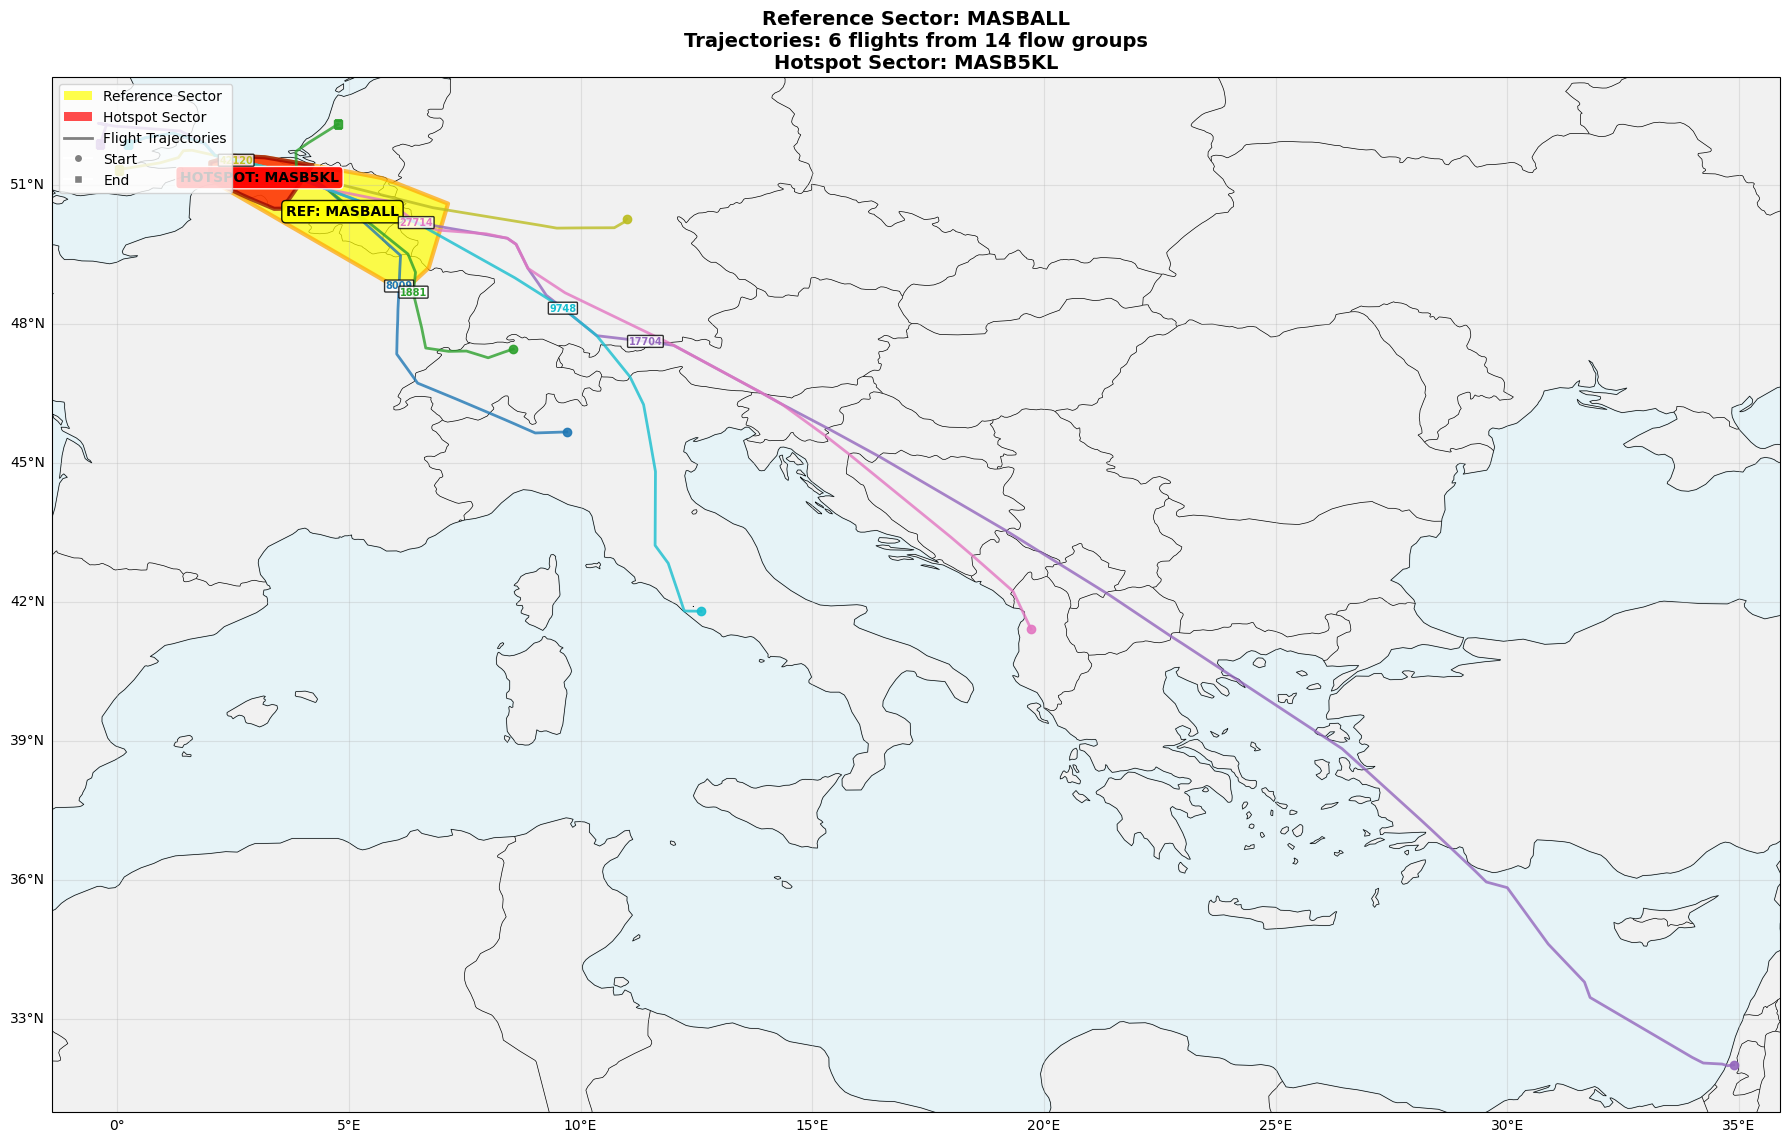


📊 Flow Group Details:
Group 1: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 2: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 3: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 4: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 5: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 6: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 7: 6 flights, Score: 3.712, Avg Similarity: 0.175
   Flights: 263860441, 263859809, 263859666, 263859088, 263857543, 263858755

Group 8: 6 flights, Score: 3.712, Avg S

In [13]:
# Manual configuration - change these values as needed
REFERENCE_SECTOR = "MASBALL"  # Change this to any reference sector from the list
HOTSPOT_SECTOR = "MASB5KL"    # Change this to any traffic volume ID

print(f"Available reference sectors: {reference_sectors[:10]}...")  # Show first 10
print(f"\nPlotting for reference sector: {REFERENCE_SECTOR}")
print(f"Hotspot sector: {HOTSPOT_SECTOR}")

plot_sector_trajectories(
    REFERENCE_SECTOR, 
    HOTSPOT_SECTOR,
    traffic_volumes, 
    trajectory_df, 
    flow_groups
)

## Reference Sector Information

Use this cell to explore all available reference sectors and their flow group counts:

In [14]:
# Analyze reference sectors
sector_stats = {}
for group in flow_groups:
    sector = group['reference_sector']
    if sector not in sector_stats:
        sector_stats[sector] = {
            'flow_groups': 0,
            'total_flights': set(),
            'max_score': 0,
            'avg_score': []
        }
    
    sector_stats[sector]['flow_groups'] += 1
    sector_stats[sector]['total_flights'].update(group['group_flights'])
    sector_stats[sector]['max_score'] = max(sector_stats[sector]['max_score'], group['score'])
    sector_stats[sector]['avg_score'].append(group['score'])

# Convert to DataFrame for easier viewing
stats_data = []
for sector, stats in sector_stats.items():
    stats_data.append({
        'Reference Sector': sector,
        'Flow Groups': stats['flow_groups'],
        'Unique Flights': len(stats['total_flights']),
        'Max Score': stats['max_score'],
        'Avg Score': np.mean(stats['avg_score'])
    })

stats_df = pd.DataFrame(stats_data)
stats_df = stats_df.sort_values('Unique Flights', ascending=False)

print(f"📊 Reference Sector Statistics (Top 20 by flight count):\n")
print(stats_df.head(20).to_string(index=False))

📊 Reference Sector Statistics (Top 20 by flight count):

Reference Sector  Flow Groups  Unique Flights  Max Score  Avg Score
          LFREST           10               7  13.086202   9.731113
         LFRQXIU           10               7  10.729121   8.128865
        LFRESTIU           10               7  10.729121   8.128865
           LFRZX           10               7  11.100415   8.336850
            LFRX           10               7  11.100415   8.336850
           LFRQX           10               7  13.086202   9.731113
         MASBALL           14               6   7.626337   4.830328
         LFBZX15           10               6  12.526527   8.009676
        LFBZNX15           10               6  13.145330   8.563299
         LFBUSUD           10               6  13.145330   8.563299
         LFRZXIU           10               6  10.395192   7.782831
          LFRXIU           10               6  10.395192   7.782831
           LFBRL           10               6  12.521660   